# Equations of motion for segbot

This notebook makes use of [SymPy](https://docs.sympy.org/), which is a Python library for symbolic mathematics.

In [1]:
import sympy as sym
import numpy as np

from sympy.physics import mechanics
mechanics.init_vprinting()

Define physical constants, consistent with the URDF file:

In [2]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

Convert all physical constants to rational numbers:

In [3]:
# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

Define variables (with a flag to indicate they are all real numbers — this helps simplify):

In [4]:
(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_R,
 tau_L) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L', real=True)

Compute equations of motion, excluding lateral and heading errors (see [Tuttle, 2014](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1415&context=open_access_theses)):

In [5]:
M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + thetadot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * thetadot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))

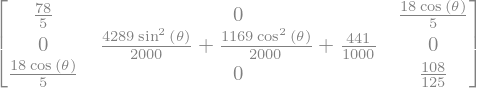

In [6]:
M

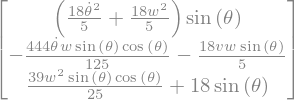

In [7]:
N

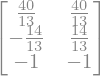

In [8]:
R

Compute full equations of motion:

In [9]:
f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [f]])

Display the vector-valued function $f$ for which the equations of motion can be written as

$$\begin{bmatrix} \dot{e}_\text{lateral} \\ \dot{e}_\text{heading} \\ \dot{v} \\ \dot{w} \\ \ddot{\theta} \end{bmatrix} = f(e_\text{lateral}, e_\text{heading}, v, w, \theta, \dot{\theta}, \tau_R, \tau_L)$$

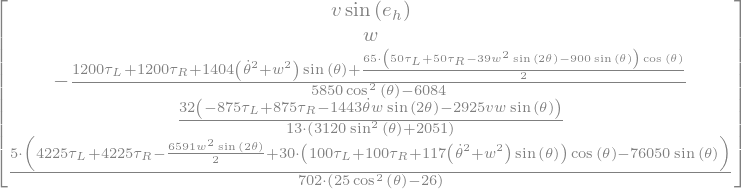

In [10]:
f

In [12]:
print(f'{mechanics.mlatex(f)}')

\left[\begin{matrix}v \sin{\left(e_{h} \right)}\\w\\- \frac{1200 \tau_{L} + 1200 \tau_{R} + 1404 \left(\dot{\theta}^{2} + w^{2}\right) \sin{\left(\theta \right)} + \frac{65 \cdot \left(50 \tau_{L} + 50 \tau_{R} - 39 w^{2} \sin{\left(2 \theta \right)} - 900 \sin{\left(\theta \right)}\right) \cos{\left(\theta \right)}}{2}}{5850 \cos^{2}{\left(\theta \right)} - 6084}\\\frac{32 \left(- 875 \tau_{L} + 875 \tau_{R} - 1443 \dot{\theta} w \sin{\left(2 \theta \right)} - 2925 v w \sin{\left(\theta \right)}\right)}{13 \cdot \left(3120 \sin^{2}{\left(\theta \right)} + 2051\right)}\\\frac{5 \cdot \left(4225 \tau_{L} + 4225 \tau_{R} - \frac{6591 w^{2} \sin{\left(2 \theta \right)}}{2} + 30 \cdot \left(100 \tau_{L} + 100 \tau_{R} + 117 \left(\dot{\theta}^{2} + w^{2}\right) \sin{\left(\theta \right)}\right) \cos{\left(\theta \right)} - 76050 \sin{\left(\theta \right)}\right)}{702 \cdot \left(25 \cos^{2}{\left(\theta \right)} - 26\right)}\end{matrix}\right]


Note that one of these ODEs is second-order — you will have to replace this with a set of two first-order ODEs, as usual.